In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def plot_weights(model):
    # 獲取模型的權重
    for i, layer in enumerate(filter(lambda x: isinstance(x, nn.Linear), model.modules())):
        weights = layer.weight.data.cpu().numpy()
        normalized_weights = weights # / np.linalg.norm(weights)
        alpha = 1# np.abs(normalized_weights)
        plt.figure()
        plt.imshow(normalized_weights, cmap='Blues', interpolation='none', alpha=alpha)
        plt.title(f'Layer {i + 1} - Weights')
        plt.colorbar()
        plt.show()

def plot_weight_distribution(model, remove_zeros=False):
    # 獲取模型的權重範圍
    weight_means = []
    weight_mins = []
    weight_maxs = []
    for i, layer in enumerate(filter(lambda x: isinstance(x, nn.Linear), model.modules())):
        weights = layer.weight.data.cpu().numpy()
        
        if remove_zeros:
            weights = weights[weights != 0]

        weight_means.append(np.mean(weights))
        weight_mins.append(np.min(weights))
        weight_maxs.append(np.max(weights))
        

    # 繪製權重分布圖
    plt.figure()
    # plt.errorbar(range(1, len(weight_means) + 1), weight_means, yerr=weight_ranges, fmt='o', capsize=4)
    plt.title('Weight Distribution of Each Layer')
    plt.xlabel('Layer Index')
    plt.ylabel('Weight Value')

    for i in range(len(weight_means)):
        # 繪製垂直線段表示範圍
        plt.vlines(x=i + 1, ymin=weight_mins[i], ymax=weight_maxs[i], color='orange')

        # 繪製水平線表示 mean
        plt.hlines(y=weight_means[i], xmin=i + 0.8, xmax=i + 1.2, color='blue', linestyle='-')
        
    plt.legend()
    plt.show()


In [ ]:
from original_models.config import get_config
from original_models import build_model

# 指定模型的路徑
cfg = 'configs/uncompressed/deit_base.yaml'
config = get_config(cfg)
model = build_model(config)
weight_path = 'elsa_subnet_weights/ELSA_deit_b_u24_9.2G.pth'

print(f"load pretrained weights of {config.MODEL.NAME} from {weight_path}")
weights = torch.load(weight_path, map_location='cpu')['model']
info = model.load_state_dict(weights)
print(info)

# 執行繪圖函數
plot_weights(model)

In [ ]:
from original_models.config import get_config
from original_models import build_model

# 指定模型的路徑
cfg = 'configs/deit_base.yaml'
config = get_config(cfg)
model = build_model(config)
# weight_path = 'elsa_subnet_weights/ELSA_deit_b_u24_9.2G.pth'
weight_path = 'elsa_subnet_weights/ELSA_deit_b_6G.pth'

print(f"load pretrained weights of {config.MODEL.NAME} from {weight_path}")
weights = torch.load(weight_path, map_location='cpu')['model']
info = model.load_state_dict(weights)
print(info)

# 執行繪圖函數
plot_weight_distribution(model, remove_zeros=True)

In [3]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

@torch.no_grad()
def get_activations(model, dataloader, device=0):
    activations = []
    activations_per_batch = []

    # Define the hook class
    class HookRecorder:
        def __init__(self, layer):
            self.layer = layer
            self.dev = self.layer.weight.device
            self.weight = layer.weight.data.clone()
            self.rows = self.weight.shape[0]
            self.columns = self.weight.shape[1]
            self.H = torch.zeros((self.columns, self.columns), device=self.dev)
            self.act = None
            self.nsamples = 0

        def hook(self, module, input, output):
            # change from tuple to tensor
            input = input[0]
            
            bs = input.shape[0]
            if self.act == None:
                self.act = torch.zeros((output.shape[1], output.shape[2]), device=self.dev)
            
            self.act = (self.act * self.nsamples + output.sum(dim=0)) / (self.nsamples + bs)
            
            if len(input.shape) == 3:
                input = input.reshape((-1, input.shape[-1]))
            input = input.t()
            self.H *= self.nsamples / (self.nsamples + bs)

            self.nsamples += bs
            
            input = math.sqrt(2 / self.nsamples) * input.float()
            self.H += input.matmul(input.t())

    # Attach the hook to each layer
    hook_layers = []
    for layer in filter(lambda x: isinstance(x, (nn.Linear)), model.modules()):
        if layer.out_features != 1000: # skip classification head
            hook_layers.append(HookRecorder(layer))
            layer.register_forward_hook(hook_layers[-1].hook)

    # Transfer model to GPU
    model.to(device)
    model.eval()

    for i, (data, target) in enumerate(tqdm(dataloader)):
        data = data.to(device)
        _ = model(data)

    return hook_layers

def plot_activations(activations):
    for i, activation in enumerate(activations):
        plt.figure()
        plt.imshow(activation, cmap='Blues', interpolation='none')
        plt.title(f'Layer {i + 1} - Activations')
        plt.colorbar()
        plt.show()

def plot_activation_distribution(activations, remove_zeros=True):
    activation_means = []
    activation_mins = []
    activation_maxs = []
    for i, activation in enumerate(activations):
        if remove_zeros:
            activation = activation[activation != 0]
            
        # outlier = activation[activation > 100]
        # print(len(activation), len(outlier), round(len(outlier) / len(activation) *100, 1), '%')

        activation_means.append(np.mean(activation))
        activation_mins.append(np.min(activation))
        activation_maxs.append(np.max(activation))
    
    # Plot activation distributions
    plt.figure()
    plt.title('Average Activation Distribution of Each Layer')
    plt.xlabel('Layer Index')
    plt.ylabel('Activation Value')

    for i in range(len(activation_means)):
        # 繪製垂直線段表示範圍
        plt.vlines(x=i + 1, ymin=activation_mins[i], ymax=activation_maxs[i], color='orange')

        # 繪製水平線表示 mean
        plt.hlines(y=activation_means[i], xmin=i + 0.8, xmax=i + 1.2, color='blue', linestyle='-')

    plt.show()


In [4]:
from utils import *
from original_models.config import get_config
from original_models import build_model

# 指定模型的路徑
cfg = 'configs/deit_base.yaml'
config = get_config(cfg)
model = build_model(config)
weight_path = 'elsa_subnet_weights/ELSA_deit_b_u24_9.2G.pth'
# weight_path = 'elsa_subnet_weights/ELSA_deit_b_6G.pth'

print(f"load pretrained weights of {config.MODEL.NAME} from {weight_path}")
weights = torch.load(weight_path, map_location='cpu')['model']
info = model.load_state_dict(weights)
print(info)


num_of_picture = 100
transform = build_transform('deit')
dataset = datasets.ImageFolder('/dataset/imagenet/val/', transform)
_, dataset = torch.utils.data.random_split(dataset, [len(dataset)-num_of_picture, num_of_picture])
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

hook_layers = get_activations(model, dataloader, device='cpu') # remove classfier head

=> merge config from configs/deit_base.yaml
load pretrained weights of deit_small from elsa_subnet_weights/ELSA_deit_b_u24_9.2G.pth
<All keys matched successfully>


/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|██████████| 13/13 [00:23<00:00,  1.77s/it]


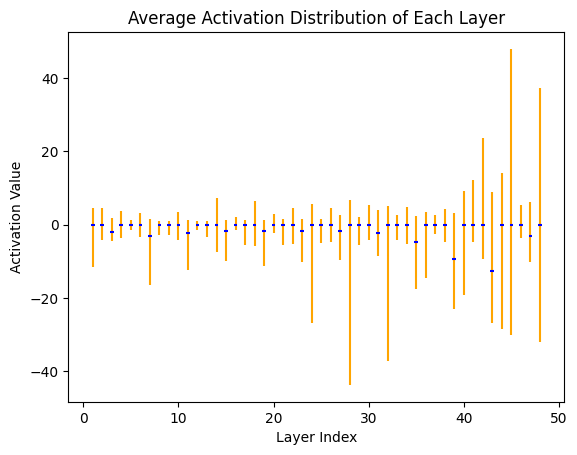

In [5]:
activations = [layer.act.numpy() for layer in hook_layers]
plot_activation_distribution(activations, remove_zeros=True)

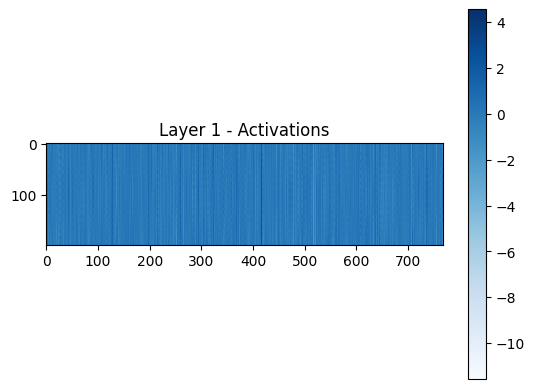

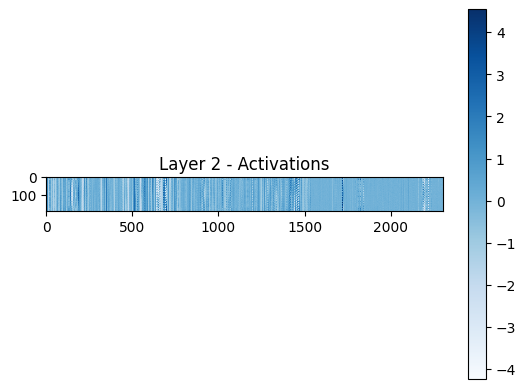

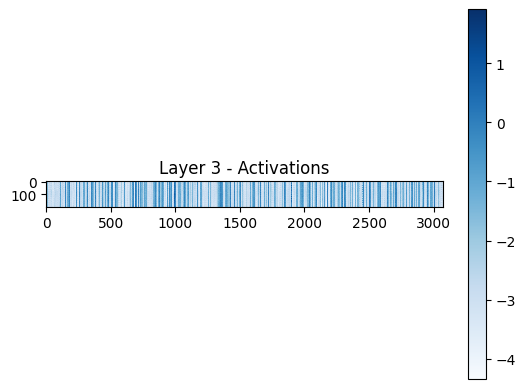

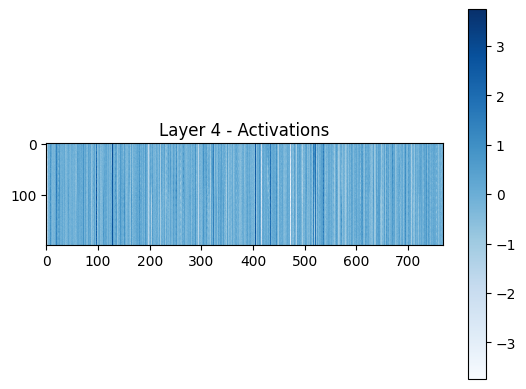

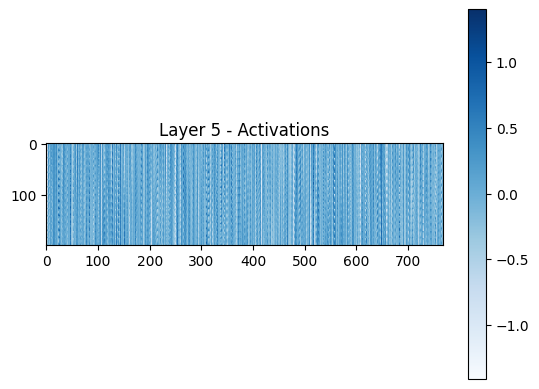

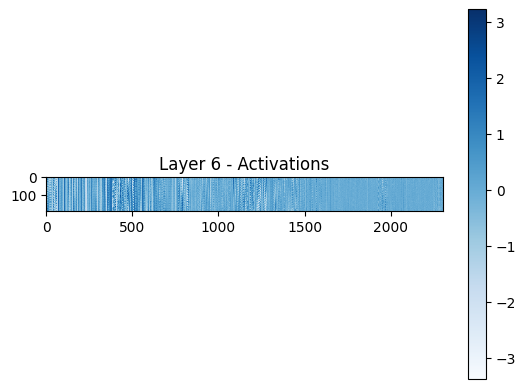

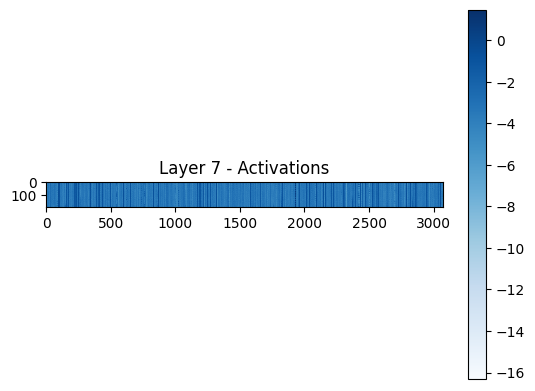

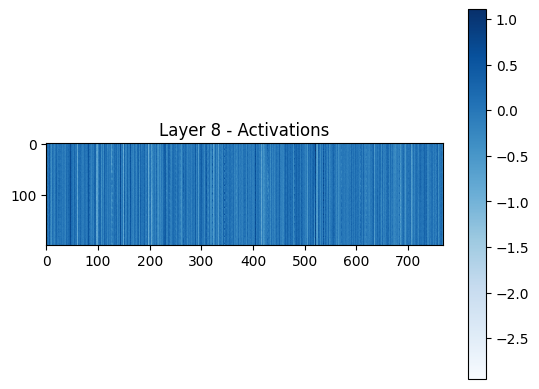

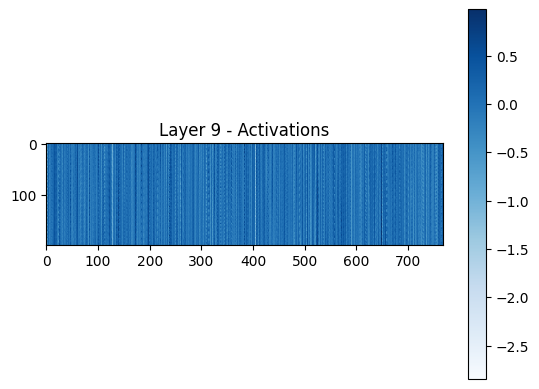

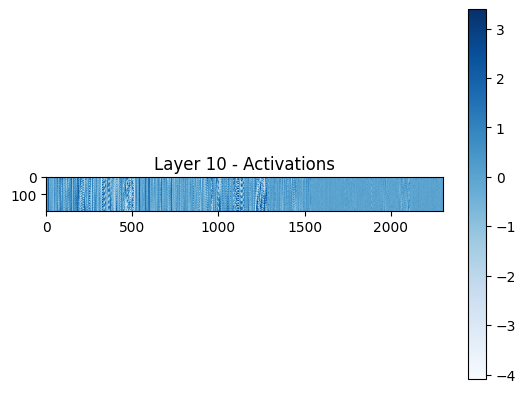

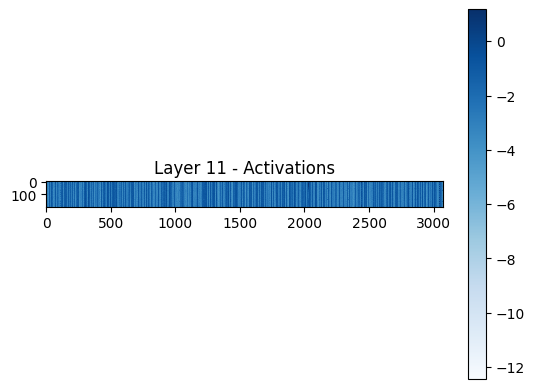

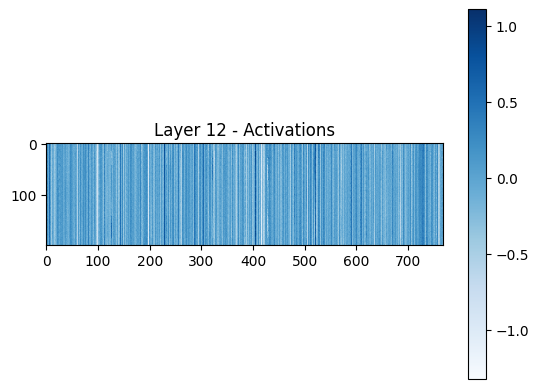

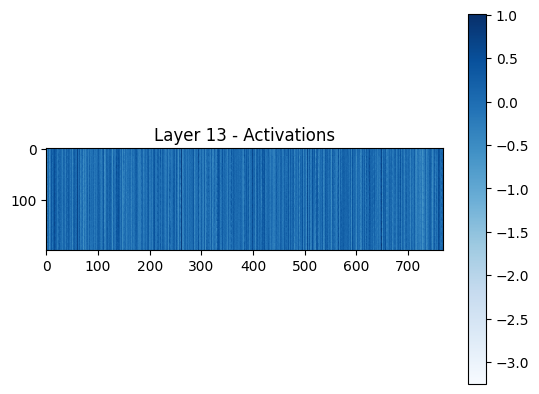

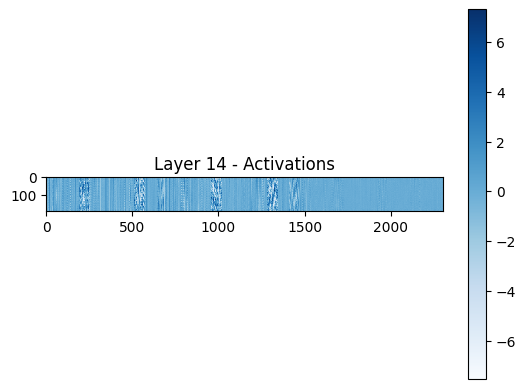

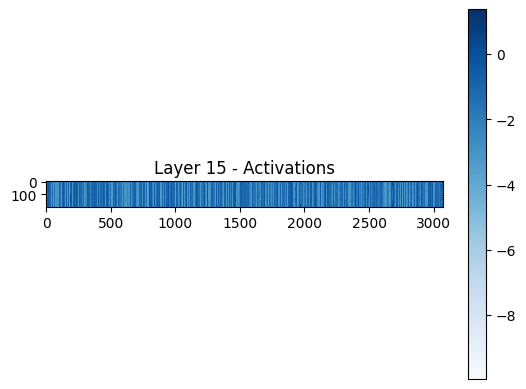

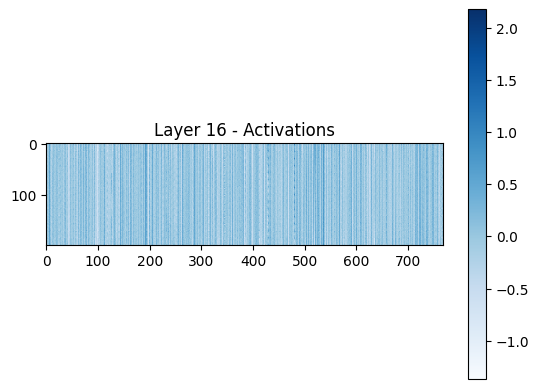

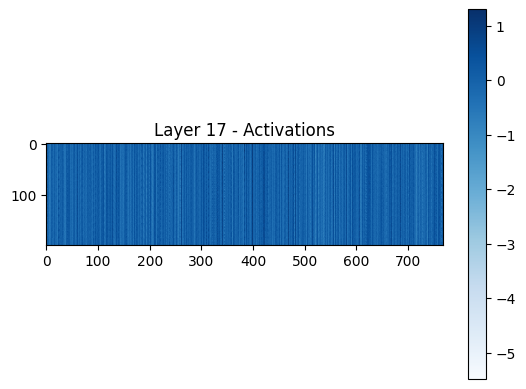

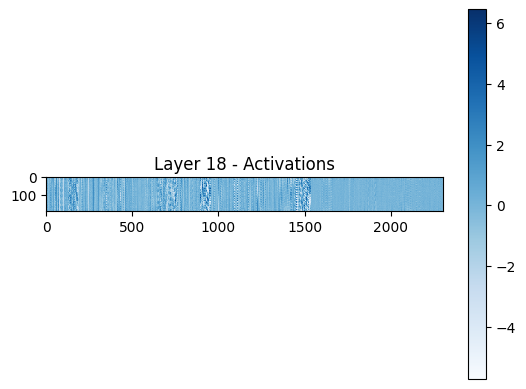

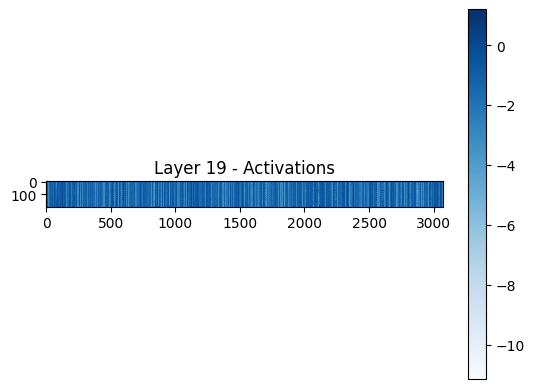

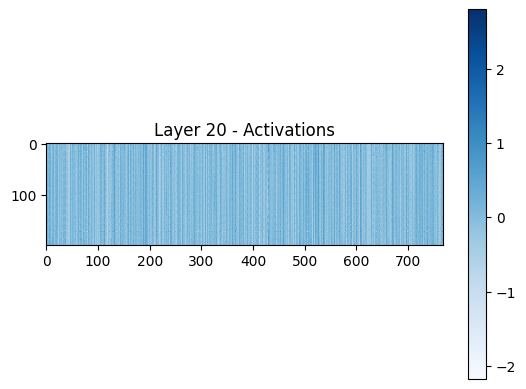

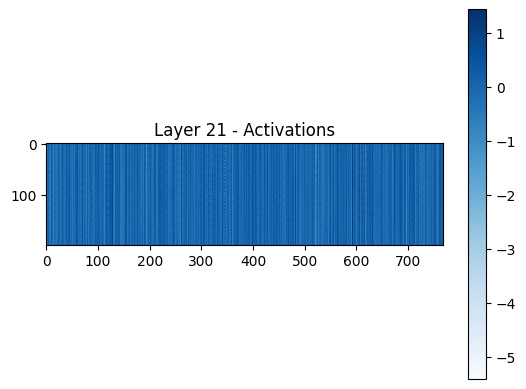

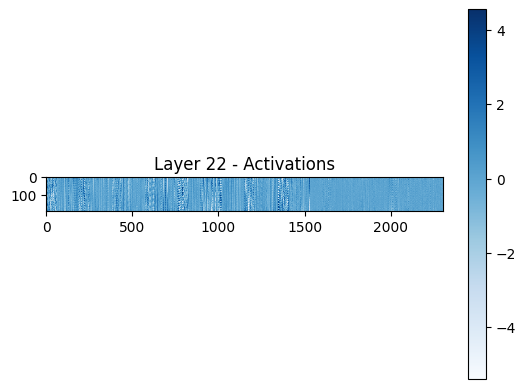

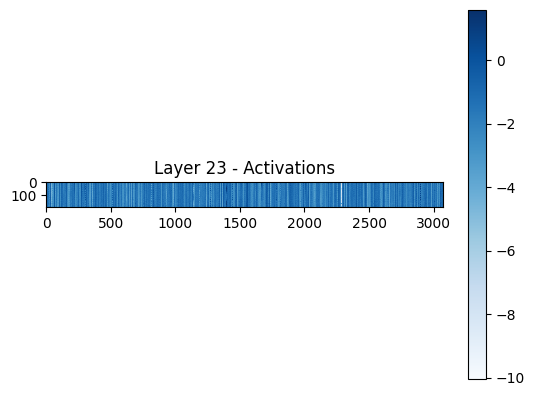

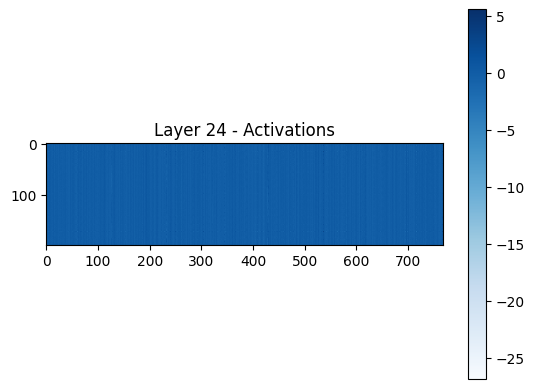

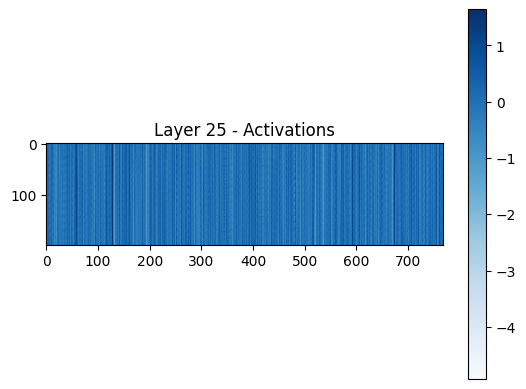

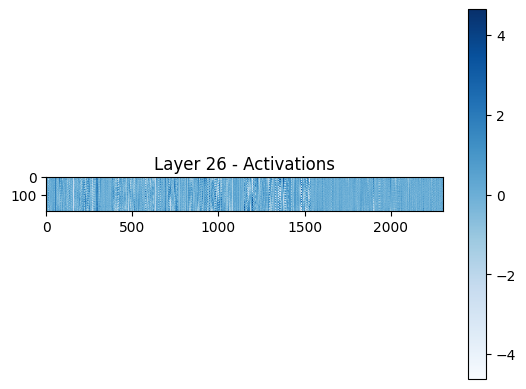

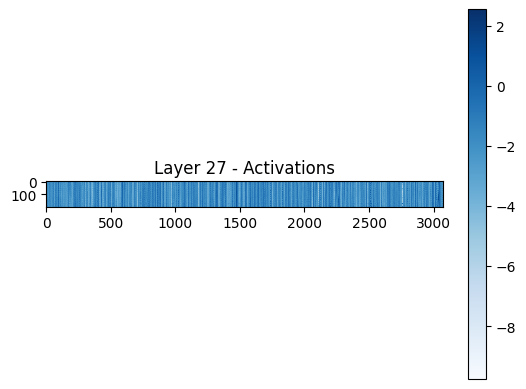

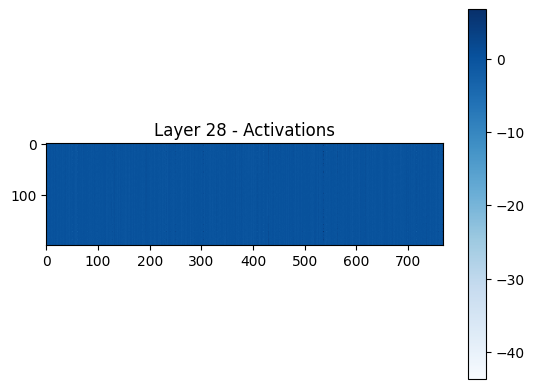

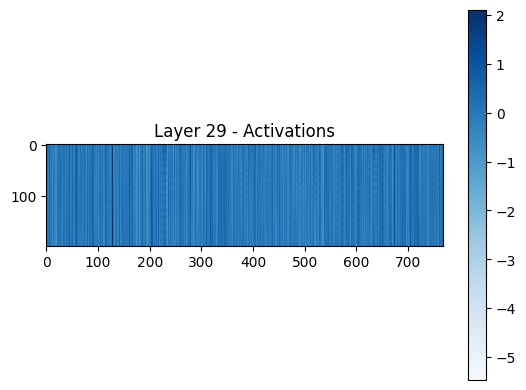

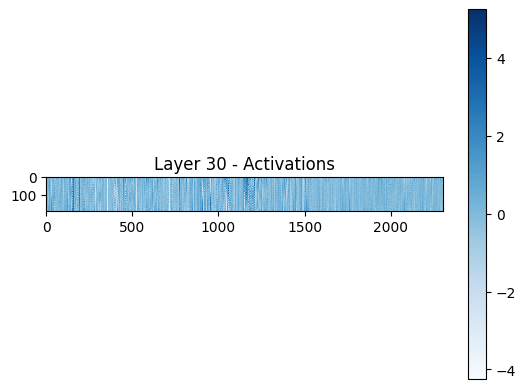

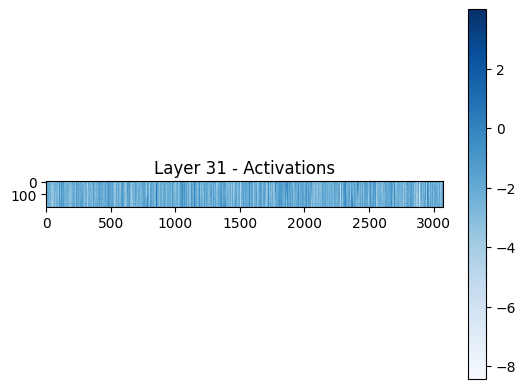

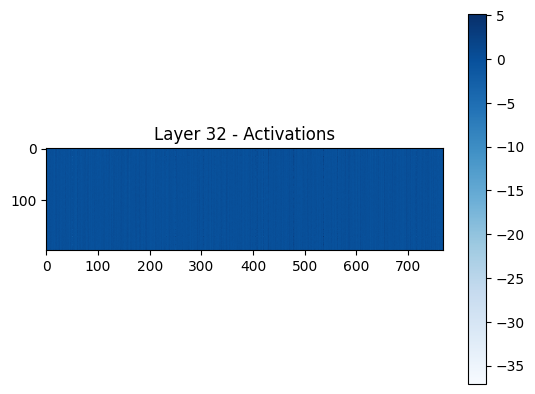

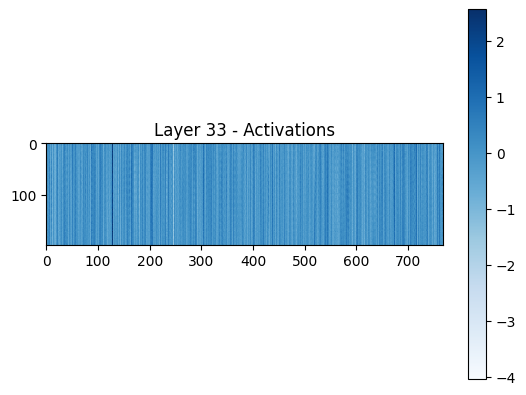

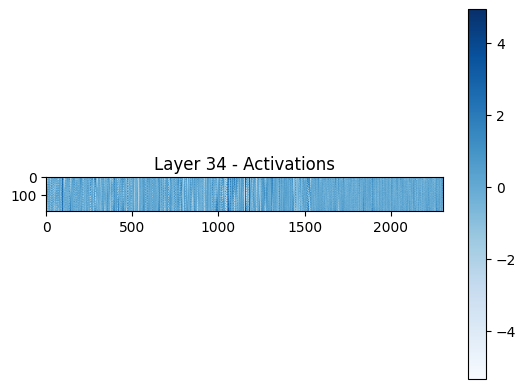

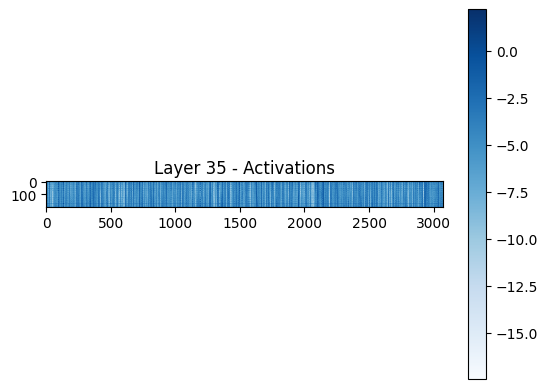

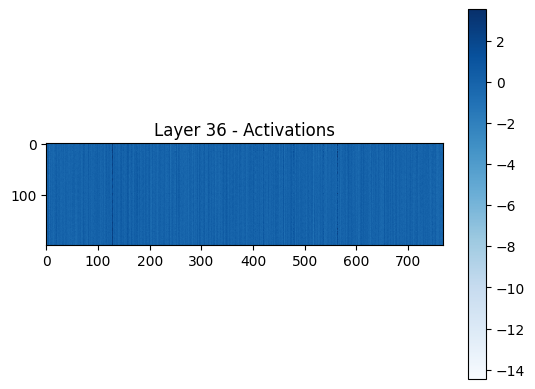

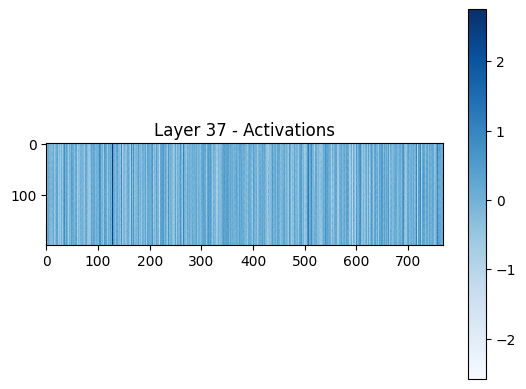

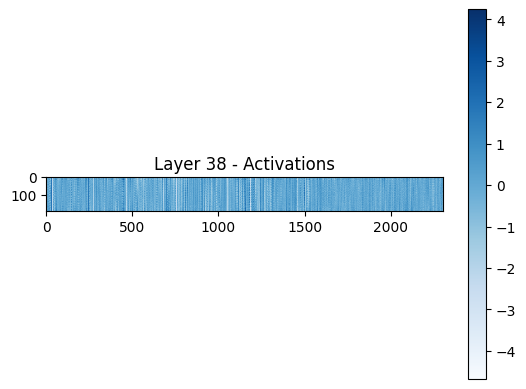

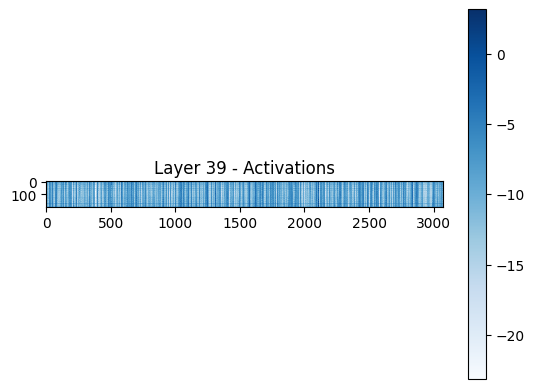

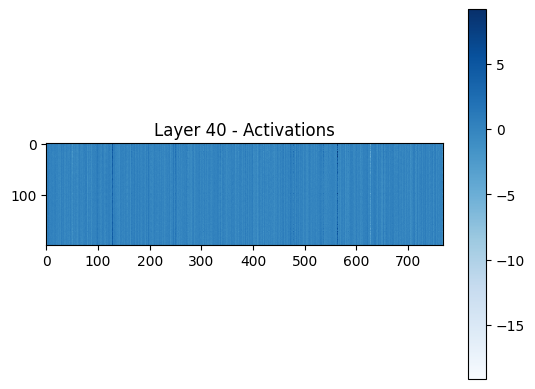

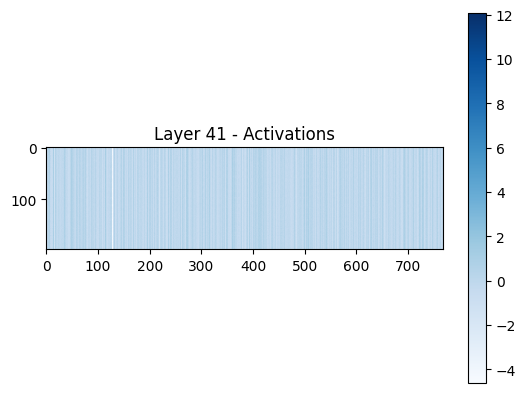

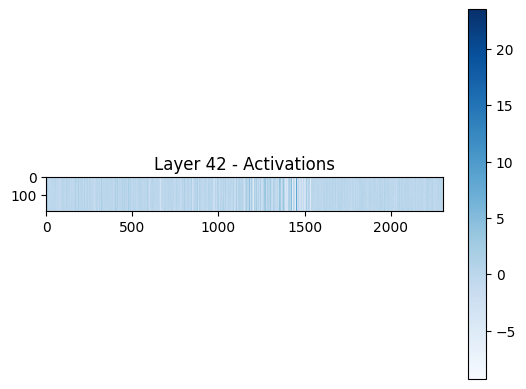

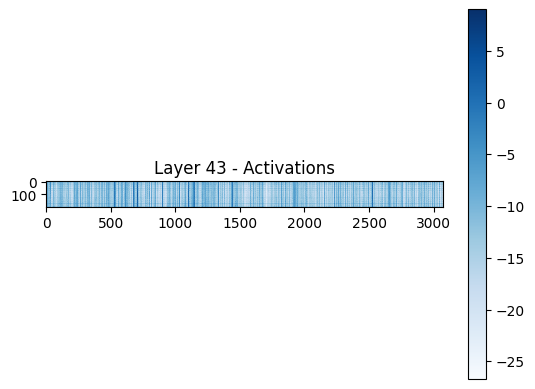

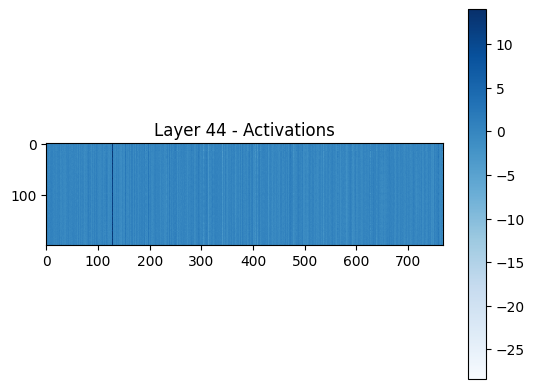

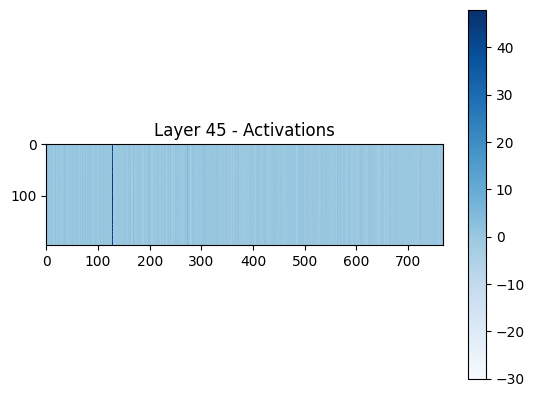

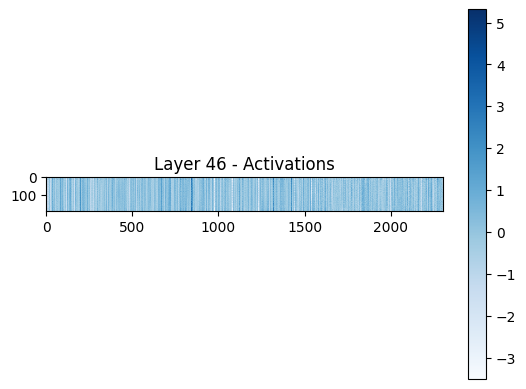

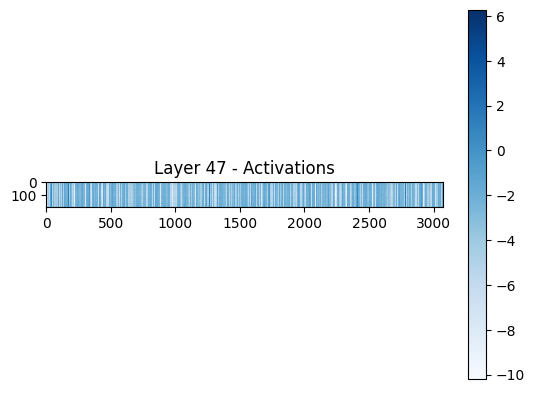

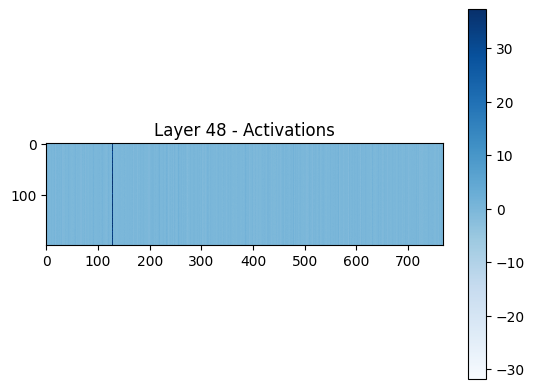

In [6]:
act = [layer.act.numpy() for layer in hook_layers]
plot_activations(act)